# Building Detection with the SpaceNet7 Dataset
> "Building footprint detection with fastai on the challenging SpaceNet7 dataset."

- toc: true
- branch: master
- badges: true
- comments: false
- categories: [satellite imagery, computer vision, fastai]
- image: images/articles/2021-spacenet7/thumbnail-gradient.png
- hide: false


## Introduction
In this notebook I implement a neural network based solution for building footprint detection on the [SpaceNet7](https://spacenet.ai/sn7-challenge/) dataset. I ignore the temporal aspect of the orginal challenge and focus on performing segmentation to detect buildings on single images. I use [fastai](https://docs.fast.ai/), a deep learning library based on PyTorch. It provides functionality to train neural networks with modern best practices while reducing the amount of boilerplate code required.

## Setup

The dataset is stored on AWS. Instructions how to install are [here](https://medium.com/the-downlinq/the-spacenet-7-multi-temporal-urban-development-challenge-algorithmic-baseline-4515ec9bd9fe).

In [1]:
#hide
!pip install fastcore==1.3.19 fastai==2.2.5 rasterio geopandas shapely wandb -Uqq

In [2]:
#hide
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#hide
from fastai.vision.all import *
from tqdm import tqdm
from pdb import set_trace
from pprint import pprint

import wandb
from fastai.callback.wandb import *

warnings.filterwarnings("ignore")

path = Path('/content/drive/My Drive/DL/LiveEO/train')
Path.BASE_PATH = path

In [4]:
#hide
# Checking what Google Colab is offering today :)
try:
  torch.cuda.get_device_properties(0)
except:
  print("No CUDA device available.")

No CUDA device available.


Defining training parameters:

In [33]:
BATCH_SIZE = 12 # 3 for xresnet50, 12 for xresnet34 with Tesla P100 (16GB)
TILES_PER_SCENE = 16
ARCHITECTURE = xresnet34
EPOCHS = 40
CLASS_WEIGHTS = [0.25,0.75]
LR_MAX = 3e-4
ENCODER_FACTOR = 10
CODES = ['Land','Building']

In [6]:
#hide
# Weights and Biases config
config_dictionary = dict(
    bs=BATCH_SIZE,
    tiles_per_scene=TILES_PER_SCENE,
    architecture = str(ARCHITECTURE),
    epochs = EPOCHS,
    class_weights = CLASS_WEIGHTS,
    lr_max = LR_MAX,
    encoder_factor = ENCODER_FACTOR
)

## Preprocessing

Exploring dataset structure, display sample scene directories:

In [8]:
#collapse 
scenes = path.ls().sorted()
print(f'Numer of scenes: {len(scenes)}')
pprint(list(scenes)[:5])

Numer of scenes: 60
[Path('L15-0331E-1257N_1327_3160_13'),
 Path('L15-0357E-1223N_1429_3296_13'),
 Path('L15-0358E-1220N_1433_3310_13'),
 Path('L15-0361E-1300N_1446_2989_13'),
 Path('L15-0368E-1245N_1474_3210_13')]


Which folders are in each scene (the last three have been added later during processing)

In [36]:
#collapse 
sample_scene = (path/'L15-0683E-1006N_2732_4164_13')
pprint(list(sample_scene.ls()))

[Path('L15-0683E-1006N_2732_4164_13/labels_match_pix'),
 Path('L15-0683E-1006N_2732_4164_13/labels_match'),
 Path('L15-0683E-1006N_2732_4164_13/images_masked'),
 Path('L15-0683E-1006N_2732_4164_13/images'),
 Path('L15-0683E-1006N_2732_4164_13/UDM_masks'),
 Path('L15-0683E-1006N_2732_4164_13/labels'),
 Path('L15-0683E-1006N_2732_4164_13/binary_mask'),
 Path('L15-0683E-1006N_2732_4164_13/img_tiles'),
 Path('L15-0683E-1006N_2732_4164_13/mask_tiles')]


How many images are in a specific scene:

In [10]:
#collapse
images_masked = (sample_scene/'images_masked').ls().sorted()
labels = (sample_scene/'labels_match').ls().sorted()
print(f'Numer of images in scene: {len(images_masked)}')
pprint(list(images_masked[:5]))

Numer of images in scene: 22
[Path('L15-0683E-1006N_2732_4164_13/images_masked/global_monthly_2018_01_mosaic_L15-0683E-1006N_2732_4164_13.tif'),
 Path('L15-0683E-1006N_2732_4164_13/images_masked/global_monthly_2018_02_mosaic_L15-0683E-1006N_2732_4164_13.tif'),
 Path('L15-0683E-1006N_2732_4164_13/images_masked/global_monthly_2018_03_mosaic_L15-0683E-1006N_2732_4164_13.tif'),
 Path('L15-0683E-1006N_2732_4164_13/images_masked/global_monthly_2018_04_mosaic_L15-0683E-1006N_2732_4164_13.tif'),
 Path('L15-0683E-1006N_2732_4164_13/images_masked/global_monthly_2018_06_mosaic_L15-0683E-1006N_2732_4164_13.tif')]


There are 60 scenes of 4km x 4km in the dataset, each containing about 24 images over the span of two years.

Let's pick one example image and its polygons:

In [11]:
image, shapes = images_masked[0], labels[0]

We use the images that have UDM masks where clouds were in the original picture:

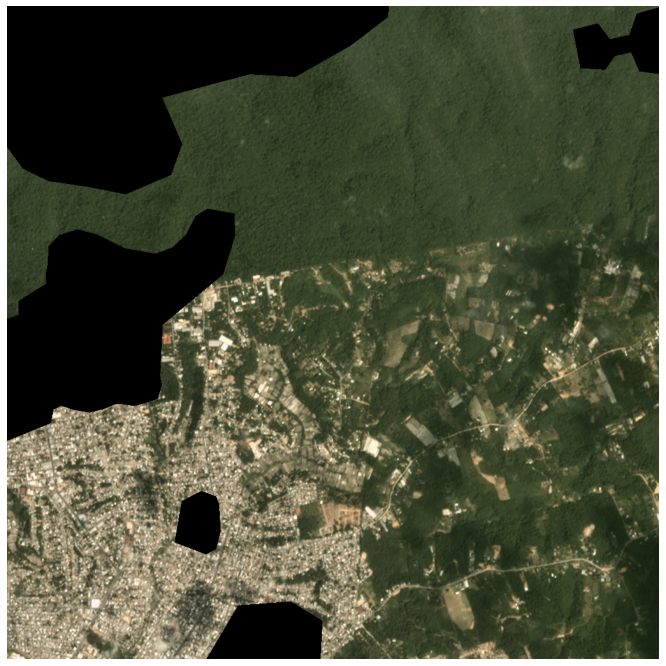

In [12]:
show_image(PILImage.create(image), figsize=(12,12));

### Creating binary masks

This is a function to generate binary mask images from geojson vector files. [Source](https://lpsmlgeo.github.io/2019-09-22-binary_mask/)

In [13]:
#collapse
import rasterio
from rasterio.plot import reshape_as_image
import rasterio.mask
from rasterio.features import rasterize

import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping, Point, Polygon
from shapely.ops import cascaded_union

# SOURCE:  https://lpsmlgeo.github.io/2019-09-22-binary_mask/

def generate_mask(raster_path, shape_path, output_path=None, file_name=None):

    """Function that generates a binary mask from a vector file (shp or geojson)
    raster_path = path to the .tif;
    shape_path = path to the shapefile or GeoJson.
    output_path = Path to save the binary mask.
    file_name = Name of the file.
    """
    
    #load raster
    
    with rasterio.open(raster_path, "r") as src:
        raster_img = src.read()
        raster_meta = src.meta
    
    #load o shapefile ou GeoJson
    train_df = gpd.read_file(shape_path)
    
    #Verify crs
    if train_df.crs != src.crs:
        print(" Raster crs : {}, Vector crs : {}.\n Convert vector and raster to the same CRS.".format(src.crs,train_df.crs))
        
        
    #Function that generates the mask
    def poly_from_utm(polygon, transform):
        poly_pts = []

        poly = cascaded_union(polygon)
        for i in np.array(poly.exterior.coords):

            poly_pts.append(~transform * tuple(i))

        new_poly = Polygon(poly_pts)
        return new_poly
    
    
    poly_shp = []
    im_size = (src.meta['height'], src.meta['width'])
    for num, row in train_df.iterrows():
        if row['geometry'].geom_type == 'Polygon':
            poly = poly_from_utm(row['geometry'], src.meta['transform'])
            poly_shp.append(poly)
        else:
            for p in row['geometry']:
                poly = poly_from_utm(p, src.meta['transform'])
                poly_shp.append(poly)

    #set_trace()
    
    if len(poly_shp) > 0:
      mask = rasterize(shapes=poly_shp,
                      out_shape=im_size)
    else:
      mask = np.zeros(im_size)
    
    # Save or show mask
    mask = mask.astype("uint8")    
    bin_mask_meta = src.meta.copy()
    bin_mask_meta.update({'count': 1})
    if (output_path != None and file_name != None):
      os.chdir(output_path)
      with rasterio.open(file_name, 'w', **bin_mask_meta) as dst:
          dst.write(mask * 255, 1)
    else: 
      return mask

Show a mask:

 Raster crs : LOCAL_CS["WGS_1984_Web_Mercator_Auxiliary_Sphere",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","3857"]], Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.


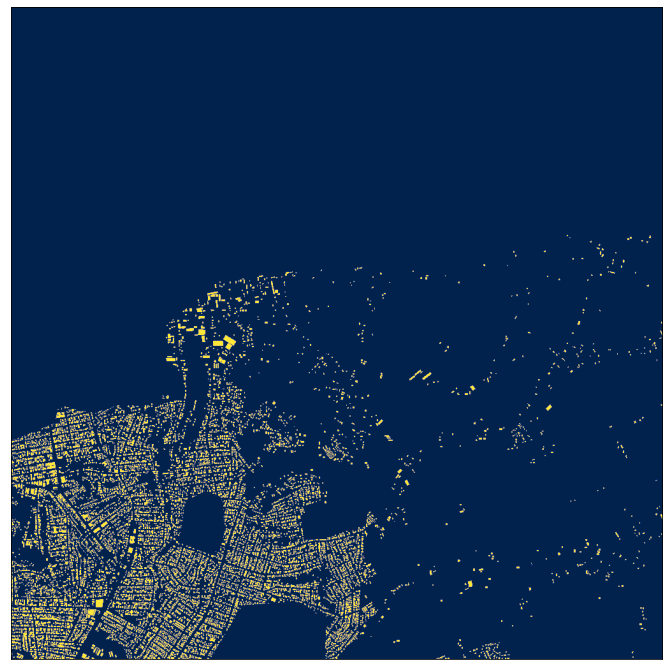

In [14]:
#collapse
mask = generate_mask(image, shapes)
plt.figure(figsize=(12,12))
plt.tight_layout()
plt.xticks([])
plt.yticks([])
plt.imshow(mask,cmap='cividis');

> Note: We can see that there - correctly - are no buildings in the mask where the UDM mask is.

Now we create and save a mask file for every image in the 'images_masked' folder of every scene.

In [14]:
#collapse
def save_masks():
  for scene in tqdm(path.ls().sorted()):
    for img in (scene/'images_masked').ls():
      shapes = scene/'labels_match'/(img.name[:-4]+'_Buildings.geojson')
      if not os.path.exists(scene/'binary_mask'/img.name):
        if not os.path.exists(scene/'binary_mask'):
          os.makedirs(scene/'binary_mask')
        generate_mask(img, shapes, scene/'binary_mask', img.name)

In [15]:
save_masks()

The mask creation failed on one image for no obvious reason. As we are planning to just use a subset of the data anyway, I simply deleted it from the training set.

### Creating subset of dataset

Let's look at how the images in a scene change over time:

<img src="../images/articles/2021-spacenet7/animated.gif" />

We can see that the ~24 images of every scene are quite similar. The vegetation changes with the seasons and some scenes show building activity, but overall the similarities are greater than the differences.

Therefore I decided to ignore most images. I originally  planned to keep every fifth image of every scene, so for example January, June, November, April, and September. This way we could make use of the variability of the different seasons. But it turned out that just selecting one image per scene yielded similar results with a fraction of the training time.

In [15]:
#collapse
def get_masked_images(path:Path, n=1)->list:
  "Returns the first `n` pictures from every scene"
  files = []
  for folder in path.ls():
    files.extend(get_image_files(path=folder, folders='images_masked')[:n])
  return files

In [18]:
#hide
# def get_masked_images(path:Path, n=None)->list:
#   "Returns every `n`th picture from every scene"
#   files = []
#   for folder in path.ls():
#     files.extend(get_image_files(path=folder, folders='images_masked')[0::n])
#   return files

In [19]:
masked_images = get_masked_images(path, 1)
len(masked_images)

60

Our dataset now consists of 60 full images.

### Cutting images in tiles

Since the images are large (1024x1024), we cut them into 16 smaller tiles (255x255) and save them to disk. Most structures are small in relation to the whole scene, so this should not hurt training too much. Smaller tiles allow for larger batch sizes and/or deeper models to fit in GPU RAM.

Most images have 1024x1024 pixels. Some images however have only 1023 pixels in one dimension, therefore I chose 255 instead of 256 as the tile size. This throws away some pixels in most images, but maintains an equal tile size for all images.

To do: Ideally, we would create overlapping tiles to avoid some buildings being cut in half and never seen in their full shape by the model.

In [149]:
#collapse
def cut_tiles(tile_size:int):
  "Cuts the large images and masks into equal tiles and saves them to disk"
  masked_images = get_masked_images(path, 5)
  for fn in tqdm(masked_images):
    scene = fn.parent.parent

    # Create directories
    if not os.path.exists(scene/'img_tiles'):
      os.makedirs(scene/'img_tiles')
    if not os.path.exists(scene/'mask_tiles'):
      os.makedirs(scene/'mask_tiles')

    # Create mask for current image
    img = np.array(PILImage.create(fn))
    msk_fn = str(fn).replace('images_masked', 'binary_mask')
    msk = np.array(PILMask.create(msk_fn))
    x, y, _ = img.shape

    # Cut tiles and save them
    for i in range(x//tile_size):
      for j in range(y//tile_size):
        img_tile = img[i*tile_size:(i+1)*tile_size,j*tile_size:(j+1)*tile_size]
        msk_tile = msk[i*tile_size:(i+1)*tile_size,j*tile_size:(j+1)*tile_size]
        Image.fromarray(img_tile).save(f'{scene}/img_tiles/{fn.name[:-4]}_{i}_{j}.png')
        Image.fromarray(msk_tile).save(f'{scene}/mask_tiles/{fn.name[:-4]}_{i}_{j}.png')

In [19]:
TILE_SIZE = 255
cut_tiles(TILE_SIZE)

## Data Loading Functions

Little helper functions

In [27]:
def get_image_tiles(path:Path, n_tiles=TILES_PER_SCENE) -> L:
  "Returns a list of the first `n` image tile filenames in `path`"
  files = L()
  for folder in path.ls():
    files.extend(get_image_files(path=folder, folders='img_tiles')[:n_tiles])
  return files

In [28]:
def get_y_fn(fn:Path) -> str:
  "Returns filename of the associated mask tile for a given image tile"
  return str(fn).replace('img_tiles', 'mask_tiles')

In [29]:
def get_y(fn:Path) -> PILMask:
  "Returns a PILMask object of 0s and 1s for a given tile"
  fn = get_y_fn(fn)
  msk = np.array(PILMask.create(fn))
  msk[msk==255] = 1
  return PILMask.create(msk)

## Visualizing the Data

Let's look at some raw image tiles and their masks.

In [80]:
#collapse
def show_tiles(n):
  all_tiles = get_image_tiles(path)
  subset = random.sample(all_tiles, n)
  fig, ax = plt.subplots(n//2, 4, figsize=(14,14))
  for i in range(n):
    y = i//2
    x = 2*i%4
    PILImage.create(subset[i]).show(ctx=ax[y, x])
    get_y(subset[i]).show(ctx=ax[y, x+1], cmap='cividis')
  fig.tight_layout()
  plt.show()

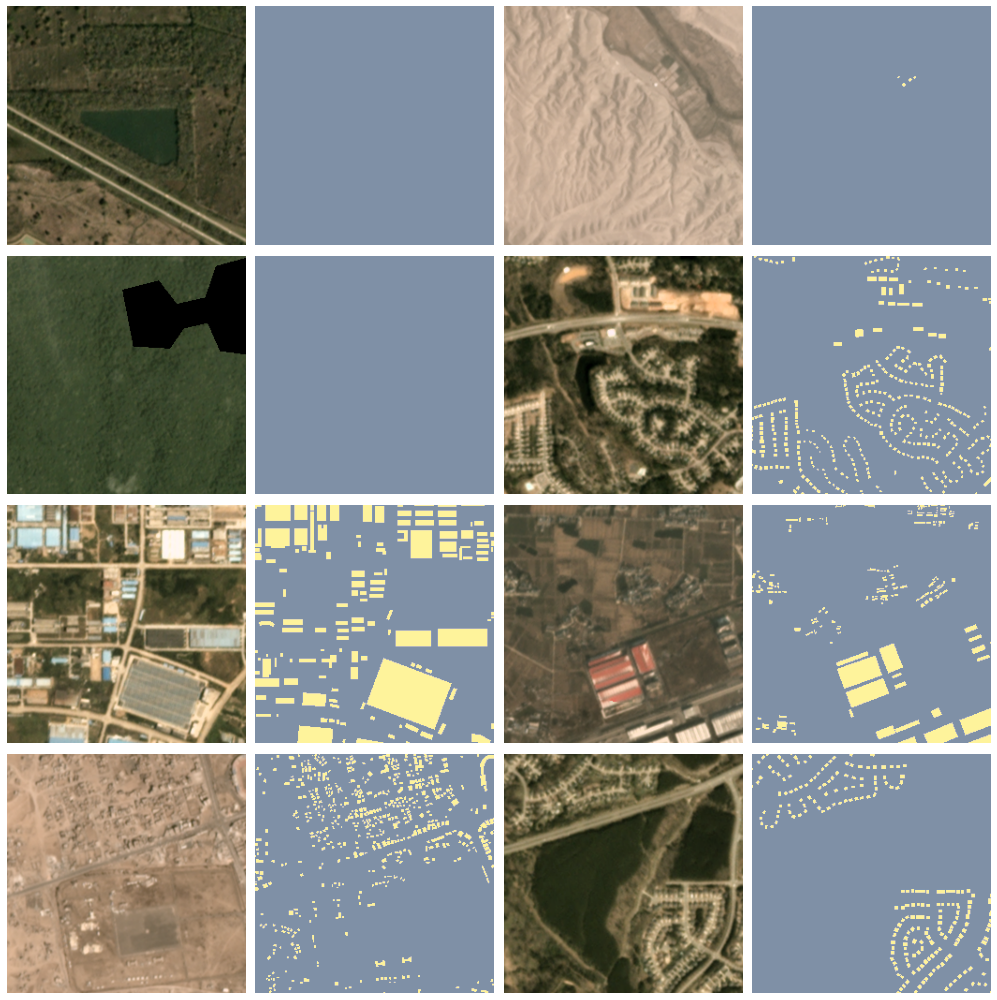

In [81]:
show_tiles(8)

### Challenges of the dataset

As we can see in the visualizations, the dataset provides some challenges:

*  The buildings are often extremely small, just a few pixels, and very close to each other
*  On the other hand, there are large structures that cover a much greater area than small buildings
*  Some buildings are hard to recognize, even for the human eye
*  The density of buildings varies greatly. There are tiles with no buildings at all, other tiles show urban scenes with hundreds of buildings.
*  The images are very diverse, with great differences in topography, vegetation and urbanization
*  Some tiles are covered partially or completely with UDM masks



### Distribution of building density

To explore how imbalanced the data is exactly, we'll analyze the percentages of building pixels in each tile. We create a simple dataloader to easily load and analyze the masks.

In [152]:
tiles = DataBlock(
      blocks = (ImageBlock(),MaskBlock(codes=CODES)),
      get_items = get_image_tiles,
      get_y = get_y
    )              
dls = tiles.dataloaders(path, bs=BATCH_SIZE)
dls.vocab = CODES                 

In [84]:
targs = torch.zeros((0,255,255))
for _, masks in dls[0]:
  targs = torch.cat((targs, masks.cpu()), dim=0)
targs.shape

(768, 255, 255)

We have 786 image tiles in total.

Calculating the percentage of building pixels vs background pixels:

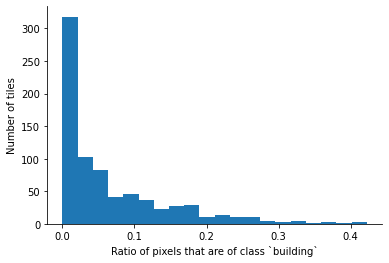

In [92]:
#collapse
total_pixels = targs.shape[1]**2
percentages = torch.count_nonzero(targs, dim=(1,2))/total_pixels
plt.hist(percentages, bins=20)
plt.ylabel('Number of tiles')
plt.xlabel('Ratio of pixels that are of class `building`')
plt.gca().spines['top'].set_color('none')
plt.gca().spines['right'].set_color('none')
plt.show()

We can see that many tiles contain no or very few buildings.

In [86]:
torch.count_nonzero((percentages==0.).float()).item()

75

75 images do not contain a single pixel of the building class, that's almost 10% of the images. These can  be areas of empty land, water, or tiles that were covered in clouds.

What is the tile with the largest percentage of buildings?

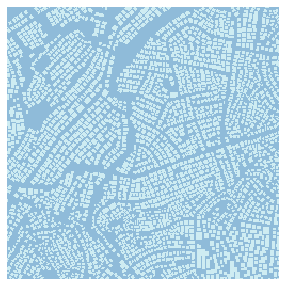

In [93]:
targs[percentages.argsort(descending=True)[0]].show();

What is the overall ratio building/background?

In [94]:
print(percentages.mean().item(), percentages.median().item())

0.06490012258291245 0.03423298895359039


On average, 6.5% of a tile's pixels are of the building class. The median is only 3.4%. This means this is a rather imbalanced dataset.

## Validation Strategy

To allow the evaluation of the performance of our model, we set aside 15% of the dataset as validation set.

We must be thoughtful about how we create this validation set. Using random images would be too easy, as we have several images per scene that differ only slightly. Our validation set would not be thoroughly separated from the training set.

Instead, I chose to randomly select 9 scenes that are used as validation data. The model will never see any images from these scenes during training.

In [20]:
VALID_SCENES = ['L15-0571E-1075N_2287_3888_13',
 'L15-1615E-1205N_6460_3370_13',
 'L15-1210E-1025N_4840_4088_13',
 'L15-1185E-0935N_4742_4450_13',
 'L15-1481E-1119N_5927_3715_13',
 'L15-0632E-0892N_2528_4620_13',
 'L15-1438E-1134N_5753_3655_13',
 'L15-0924E-1108N_3699_3757_13',
 'L15-0457E-1135N_1831_3648_13']

In [21]:
def valid_split(item):
  scene = item.parent.parent.name
  return scene in VALID_SCENES

## Undersampling

To help mitigating the imbalanced classes, we remove all tiles that contain no buildings at all from the training set. This reduces the amount of samples by ~10%, thereby accelerating the training while helping the model perform better.

In [22]:
#collapse
def has_buildings(fn:Path) -> bool:
  """Returns whether the mask of a given image tile
  contains at least one pixel of a building"""
  fn = get_y_fn(fn)
  msk = tensor(PILMask.create(fn))
  count = torch.count_nonzero(msk)
  return count>0.

In [23]:
#collapse
def get_undersampled_tiles(path:Path) -> L:
  """Returns a list of image tile filenames in `path`.
  For tiles in the training set, empty tiles are ignored.
  All tiles in the validation set are included."""

  files = get_image_tiles(path)
  train_idxs, valid_idxs = FuncSplitter(valid_split)(files)
  train_files = L(filter(has_buildings, files[train_idxs]))
  valid_files = files[valid_idxs]

  return train_files + valid_files

## Creating Dataloaders

The following transformations seem reasonable for satellite images. We flip the tiles vertically and horizontally, rotate them, change brightness, contrast and saturation by a small amount. We normalize them according to ImageNet stats, so that we can use a pretrained model later.

In [24]:
tfms = [Dihedral(0.5),              # Horizontal and vertical flip
        Rotate(max_deg=180, p=0.9), # Rotation in any direction possible
        Brightness(0.2, p=0.75),
        Contrast(0.2),
        Saturation(0.2),
        Normalize.from_stats(*imagenet_stats)]

To create the datasets, we use the convenient DataBlock API of fastai. We only load 16 tiles per scene, so only 1 image per region.

In [30]:
tiles = DataBlock(
      blocks = (ImageBlock(),MaskBlock(codes=CODES)), # Independent variable is Image, dependent variable is Mask
      get_items = get_undersampled_tiles,             # Collect undersampled tiles
      get_y = get_y,                                  # Get dependent variable: mask
      splitter = FuncSplitter(valid_split),           # Split into training and validation set
      batch_tfms = tfms                               # Transforms on GPU: augmentation, normalization
    )                              

In [32]:
dls = tiles.dataloaders(path, bs=BATCH_SIZE)
dls.vocab = CODES

In [165]:
len(dls.train_ds), len(dls.valid_ds)

(741, 144)

We have 741 tiles in the training set and 144 tiles in the validation set.

Making sure the batches look okay:

In [166]:
inputs, targets = dls.one_batch()

In [167]:
inputs.shape, targets.shape

((12, 3, 255, 255), (12, 255, 255))

These dimensions are as expected:
- 12 images per batch
- 3 channels for the input images
- no color channels for the target mask
- image size: 255x255.

Check that the mask looks as expected, 0s and 1s:

In [168]:
targets[0].unique()

TensorMask([0, 1])

## Defining the Model

The task at hand is an image segmentation problem. In the original competition, it is required to assign individual labels to each building to keep track of it over time (*instance segmentation*). Here, I chose to do *semantic segmentation* instead, so just classifying for every pixel if it belongs to a building or not.

The fastai library allows the remarkably simple creation of a U-Net, a standard architecture for image segmentation problems. The module [DynamicUNet](https://docs.fast.ai/vision.models.unet#DynamicUnet) - provided with an encoder architecture - automatically constructs a decoder and cross connections. This makes it easy to build a U-Net out of different (and pretrained) architectures.  I chose this approach to have more time to experiment instead of writing code from scratch. I considered following aspects:


*   Encoder: I picked a xResNet34 model that has been pretrained on ImageNet. A 34-layer encoder seems like a good compromise between accuracy and memory/compute requirements.
*   Loss function: The choice of the loss function is important for segmentation problems. I'll use a weighted pixel-wise cross-entropy loss. The weights are important for the imbalanced dataset.
*   Optimizer: I use the default optimizer, Adam.
*   Metrics:
  *  As the classes are very imbalanced, a simple accuracy metric would not be helpful. In a picture with 3% buildings, the model could predict "no building" on every pixel and still get 97% accuracy.
  *  Instead, I focus on the Dice metric, it is often used for segmentation tasks. It is equivalent to the F1 score and measures the ratio of $\frac{2TP}{2TP + FP + FN}$
  *  Additionally, I added foreground_acc of fastai, it measures the percentage of foreground pixels correctly classified, the  **Recall**. Foreground in this case is the building class.


In [ ]:
weights = Tensor(CLASS_WEIGHTS).cuda()
loss_func = CrossEntropyLossFlat(axis=1, weight=weights)

With some experimentation, the class weights 0.25 for the background and 0.75 for the building class seem to work fine.

In [47]:
learn = unet_learner(dls,                                 # DataLoaders
                     ARCHITECTURE,                        # xResNet34
                     loss_func = loss_func,               # Weighted cross entropy loss
                     opt_func = Adam,                     # Adam optimizer
                     metrics = [Dice(), foreground_acc],  # Custom metrics
                     self_attention = False,
                     cbs = [SaveModelCallback(
                              monitor='dice',
                              comp=np.greater,
                              fname='best-model'
                            )]
                     )

In [113]:
#hide
# For experiments with Mish activation function
# def replace_relu_to_mish(model):
#     for child_name, child in model.named_children():
#         if isinstance(child, nn.ReLU):
#             setattr(model, child_name, Mish())
#         else:
#             # recurse
#             replace_relu_to_mish(child)

# replace_relu_to_mish(learn.model)

Summary of the model:

In [49]:
#collapse_output
learn.summary()

DynamicUnet (Input shape: 12)
Layer (type)         Output Shape         Param #    Trainable 
                     12 x 32 x 128 x 128 
Conv2d                                    864        False     
BatchNorm2d                               64         True      
ReLU                                                           
Conv2d                                    9216       False     
BatchNorm2d                               64         True      
ReLU                                                           
____________________________________________________________________________
                     12 x 64 x 128 x 128 
Conv2d                                    18432      False     
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                              

This is the full UNet model:

In [50]:
#collapse_output
learn.model

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): ConvLayer(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): ConvLayer(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (2): ConvLayer(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): ResBlock(
          (convpath): Sequential(
            (0): ConvLayer(
              (0): Conv2d(64, 64, kernel_size=(

## Training

We can use fastai's learning rate finder to pick a reasonable learning rate:

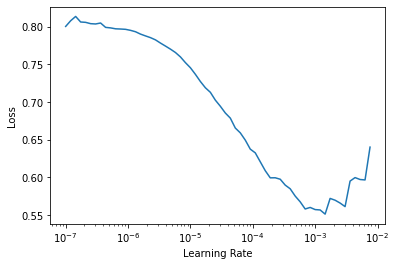

In [51]:
learn.lr_find(suggestions=False)

Somewhere around 1e-4 seems reasonable, where the loss decreases steadily.

In [52]:
lr_max = LR_MAX # 3e-4

We unfreeze the model to train the encoder and decoder simultaneously. The encoder should be trained at a lower learning rate, since we don't want to change the pretrained features too much. This is achieved by setting the learning rate to `slice(lr_max/10, lr_max)`

We use the `fit_one_cycle` method, where the learning rate starts low for a warm up period, reaches a maximum of `lr_max` and then anneals to 0 at the end of training.

In [53]:
#hide
wandb.init(project="spacenet7", entity="johannesstutz", config=config_dictionary)

wandb: Currently logged in as: johannesstutz (use `wandb login --relogin` to force relogin)


In [54]:
#hide
#learn.unfreeze()
#learn.fit_flat_cos(EPOCHS, lr=slice(lr_max/ENCODER_FACTOR, lr_max), wd=WEIGHT_DECAY, cbs=[WandbCallback()])

In [56]:
#collapse-output
learn.unfreeze()
learn.fit_one_cycle(
    EPOCHS,
    lr_max=slice(lr_max/ENCODER_FACTOR, lr_max),
    cbs=[WandbCallback()]
)

Better model found at epoch 0 with dice value: 0.39107538560859856.
Better model found at epoch 1 with dice value: 0.44738810775540105.
Better model found at epoch 2 with dice value: 0.4726468094476467.
Better model found at epoch 3 with dice value: 0.5109467766474319.
Better model found at epoch 5 with dice value: 0.522520106907844.
Better model found at epoch 6 with dice value: 0.5346689714876461.
Better model found at epoch 8 with dice value: 0.5473970212354816.
Better model found at epoch 17 with dice value: 0.5503762926921414.
Better model found at epoch 20 with dice value: 0.5515343305053996.
Better model found at epoch 21 with dice value: 0.5637505598945902.
Better model found at epoch 28 with dice value: 0.5670905400610845.
Better model found at epoch 29 with dice value: 0.5675068699781953.
Better model found at epoch 31 with dice value: 0.5687503342169392.
Better model found at epoch 34 with dice value: 0.5727276523723746.


The best model at epoch 34 has a Dice score of `0.572`. The theoretic maximum - a perfect segmentation - is `1.0`. We'll see how our results look like in the following visualizations.

In [57]:
#hide
wandb.finish()

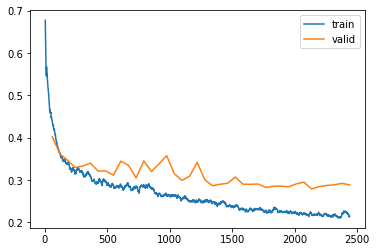

In [58]:
learn.recorder.plot_loss()

In [59]:
learn.load('best-model');

In [ ]:
#hide
#learn.save(path/'xresnet34-dice-575')

In [66]:
#hide
#learn.load(path/'xresnet34-dice-575');

## Visualizing the Results

> Note: The following results actually come from the model of a different training run, also with a Dice score of 0.57

Let's get all predictions on the validation set and have a look at them.

In [ ]:
probs,targets,preds,losses = learn.get_preds(dl=dls.valid,
                                             with_loss=True,
                                             with_decoded=True,
                                             act=None)

Sort descending by loss:

In [68]:
loss_sorted = torch.argsort(losses, descending=True)
n = len(loss_sorted)

Helper function to show predictions:

In [69]:
#collapse
def show_single_pred(index:int):
  fig, ax = plt.subplots(1, 4, figsize=(20,5))
  dls.valid_ds[index][0].show(ctx=ax[0]);
  ax[0].set_title("Input")
  show_at(dls.valid_ds, index, cmap='Blues', ctx=ax[1]);
  ax[1].set_title("Target")
  preds[index].show(cmap='Blues', ctx=ax[2]);
  ax[2].set_title("Prediction Mask")
  probs[index][1].show(cmap='viridis', ctx=ax[3]);
  ax[3].set_title("Building class probability")

### Plot the samples with the highest losses

Tile #94, loss: 0.4202008843421936
Tile #85, loss: 0.35915520787239075
Tile #68, loss: 0.33037257194519043


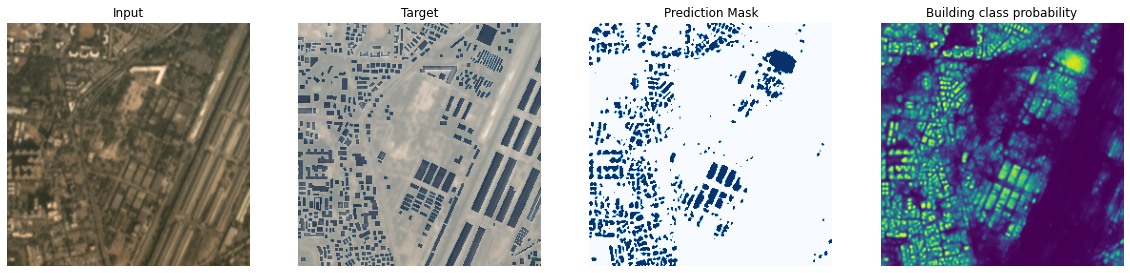

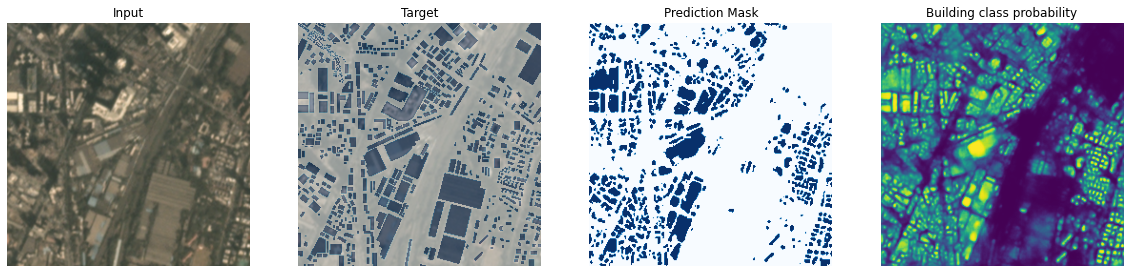

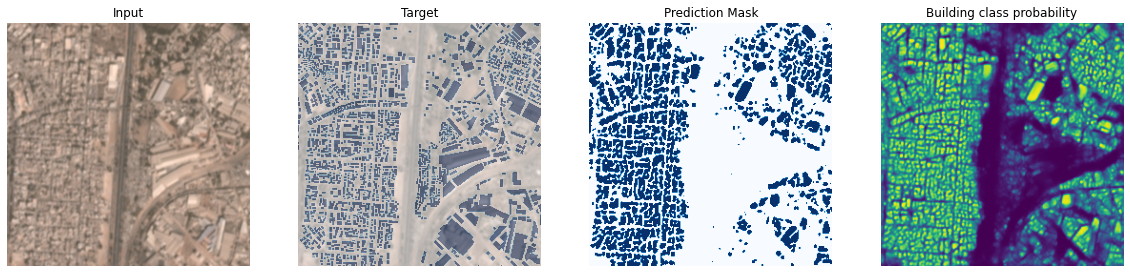

In [70]:
#collapse
for idx in loss_sorted[:3]:
  print(f'Tile #{idx}, loss: {losses[idx]}')
  show_single_pred(idx)

All images with the highest losses show dense urban areas. What's noticable is the trouble that the model has with large buildings, which are often completely overlooked. It's also clear that very small buildings are merged into "blobs". I suspect tracking individual buildings could be difficult here.

### Plot samples with medium losses

Tile #62, loss: 0.05976606160402298
Tile #134, loss: 0.05932387337088585
Tile #13, loss: 0.05887886509299278


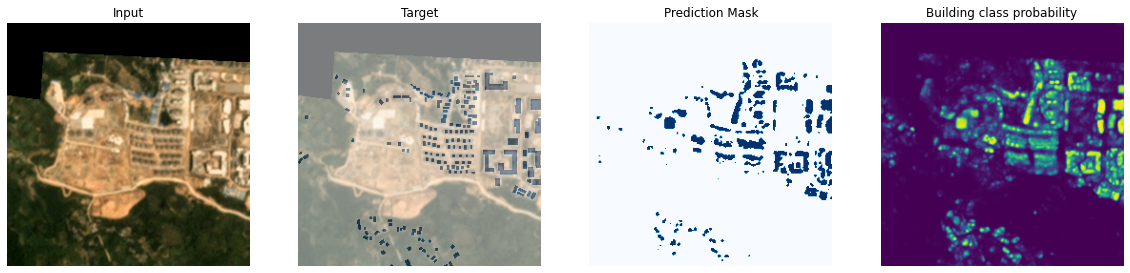

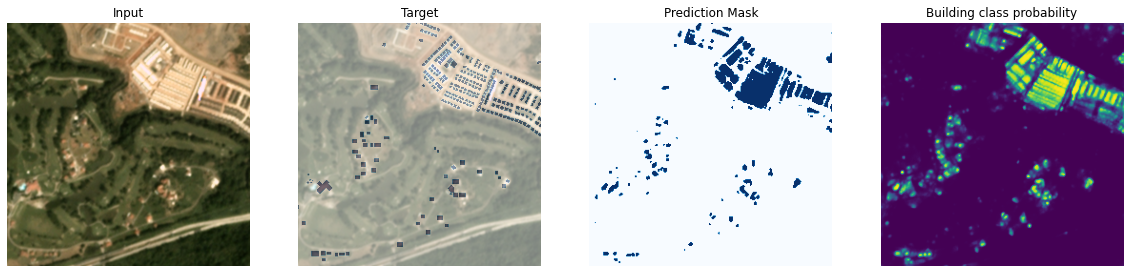

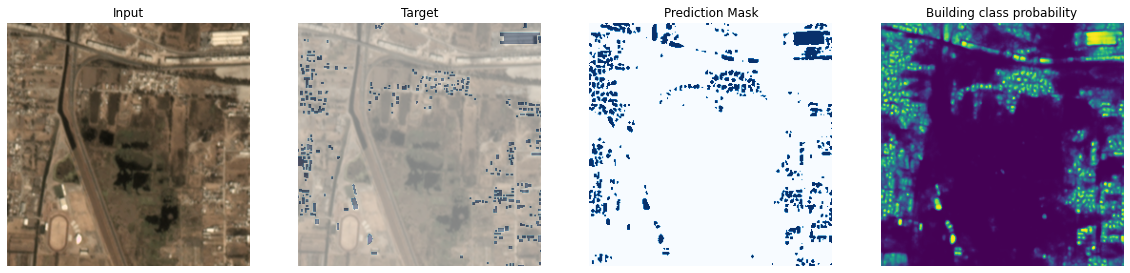

In [71]:
#collapse
for idx in loss_sorted[n//2-1:n//2+2]:
  print(f'Tile #{idx}, loss: {losses[idx]}')
  show_single_pred(idx)

The model tends to merge small buildings into larger blobs, and there are several false positives. But there are also some quite good predictions, picking up buildings that are hard even for the human eye to pick up.

### Plot some examples with low losses

Tile #42, loss: 0.004398711025714874
Tile #79, loss: 0.0039534792304039
Tile #104, loss: 0.003881581127643585


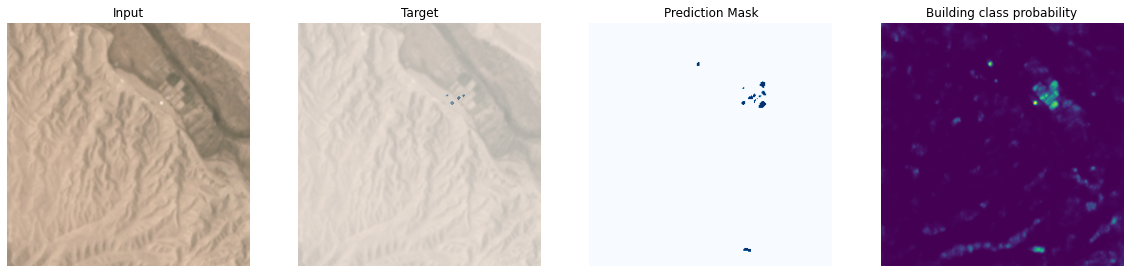

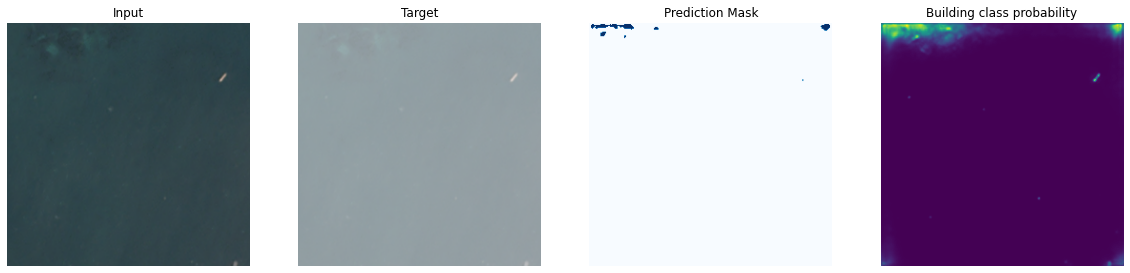

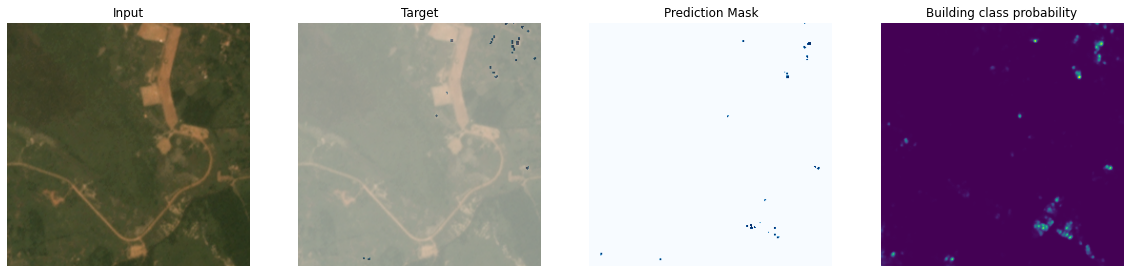

In [73]:
#collapse
for idx in loss_sorted[-21:-18]:
  print(f'Tile #{idx}, loss: {losses[idx]}')
  show_single_pred(idx)

The model shows mixed performance in images with few buildings in them. Overall, the accuracy looks better here than in dense areas. But the model tends to produce false positives; and some tiles show weird artifacts in the corners. It seems as if the model interprets the corners itself as buildings, especially on tiles covered with water.

### Show complete scenes

Predict all tiles of a scene:

In [77]:
#collapse
def save_predictions(scene, path=path) -> None:
  "Predicts all 16 tiles of one scene and saves them to disk"
  output_folder = path/scene/'predicted_tiles'
  if not os.path.exists(output_folder):
    os.makedirs(output_folder)
  tiles = get_image_files(path/scene/'img_tiles').sorted()
  for i in range(16):
    tile_preds = learn.predict(tiles[i])
    to_image(tile_preds[2][1].repeat(3,1,1)).save(output_folder/f'{i:02d}.png')

In [78]:
scene = VALID_SCENES[0] # 'L15-0571E-1075N_2287_3888_13'

In [79]:
save_predictions(scene)

Helper function to show several tiles as a large image:

In [114]:
#collapse
def unblockshaped(arr, h, w):
    """
    Return an array of shape (h, w) where
    h * w = arr.size

    If arr is of shape (n, nrows, ncols), n sublocks of shape (nrows, ncols),
    then the returned array preserves the "physical" layout of the sublocks.

    Source: https://stackoverflow.com/a/16873755
    """
    try: # with color channel
      n, nrows, ncols, c = arr.shape
      return (arr.reshape(h//nrows, -1, nrows, ncols, c)
                .swapaxes(1,2)
                .reshape(h, w, c))
    except ValueError: # without color channel
      n, nrows, ncols = arr.shape
      return (arr.reshape(h//nrows, -1, nrows, ncols)
                .swapaxes(1,2)
                .reshape(h, w))

Load saved predictions:

In [84]:
#collapse
def get_saved_preds(scene, path=path):
  "Load saved prediction mask tiles for a scene and return image + assembled mask"
  image_file = (path/scene/'images_masked').ls()[0]
  image = load_image(image_file)

  mask_tiles = get_image_files(path/scene/'predicted_tiles').sorted()
  mask_arrs = np.array(list(maps(partial(load_image, mode="L"), np.asarray, mask_tiles)))
  mask_array = unblockshaped(np.array(mask_arrs), 1020, 1020)

  return (image, mask_array)

Show image + stitched predictions:

In [85]:
#collapse
def show_complete_preds(image, mask_array, scene):
  "Source: https://github.com/CosmiQ/CosmiQ_SN7_Baseline/blob/master/notebooks/sn7_baseline.ipynb"
  figsize = (25, 16)
  fig, (ax0, ax1) = plt.subplots(1, 2, figsize=figsize)
  _ = ax0.imshow(image)
  ax0.set_xticks([])
  ax0.set_yticks([])
  ax0.set_title('Image')
  _ = ax1.imshow(mask_array, cmap='viridis')
  ax1.set_xticks([])
  ax1.set_yticks([])
  ax1.set_title('Prediction Mask')
  plt.suptitle(scene)
  plt.tight_layout()
  plt.savefig(os.path.join(path, scene + '_im0+mask0+dice575.png'))
  plt.show()

In [ ]:
show_complete_preds(*get_saved_preds(scene), scene)

<img src="../images/articles/2021-spacenet7/fullscene1.jpg" />

In [ ]:
# hide
# for scene in VALID_SCENES:
#   save_predictions(scene)
#   show_complete_preds(*get_saved_preds(scene), scene)

## Discussion

I'm not sure how to rate the results because I don't have any comparison. A Dice score of `0.57` doesn't sound great. But considering how difficult the dataset is and that I didn't customize the architecture at all, I'm quite pleased with the result. There is a lot to improve however! The original SpaceNet7 challenge required recognizing individual buildings and tracking them trough time, that's something I'd like to work on in the future.

### What worked?
*  Using a **pretrained encoder**.
*  **Ignoring most images** of the dataset. I tried using `5` instead of `1` images per scene, which increased training time by `5` but did not improve the results significantly.
*  Standard **data augmentations**. Without them, the model started to overfit sooner.
*  **Undersampling**. While it did not have a large effect, it sped up training a little bit and it helped the accuracy.
*  **Weighted cross-entropy loss**. Without the weights, the model had a strong bias towards the dominating `background` class and failed to recognize many buildings.

### What didn't?
*  I hoped to get faster training with the **`Mish` activation function**, but training was unstable.
*  **Dice loss** instead of cross-entropy loss was unstable as well.
*  I tried adding **self-attention** to the U-Net, I hoped it would help classifying larger structures. I did not notice a significant difference.
*  A **deeper xResNet50 encoder** that I tried increased training time `6`-fold, but did not improve results.

### Other ideas to improve results
* Better **data processing**: using overlapping tiles, scaling up the image tiles
* Dynamic **thresholding** for turning the predicted probabilities into a binary mask.
* Implement **recent advancements** in segmentation models, ie [UNet with ASPP](https://www.researchgate.net/figure/The-improved-U-net-with-atrous-spatial-pyramid-pooling-ASPP-integration-The-ASPP_fig3_332737684) or [Eff-UNet](https://openaccess.thecvf.com/content_CVPRW_2020/papers/w22/Baheti_Eff-UNet_A_Novel_Architecture_for_Semantic_Segmentation_in_Unstructured_Environment_CVPRW_2020_paper.pdf)
* **More compute**: Deeper models. Use cross-validation with several folds to utilize all 60 scenes. Ensemble different models.

Thank you for reading this far! The challenge was fun and I learned a lot. There is also a lot of room for improvement and work to do :)